In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config as cfg
import seaborn as sns
import ds_functions as ds
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from data import hf_data, hf_data_raw, t_data, t_data_raw

def KFold(X, y, nfolds):
    skf = StratifiedKFold(n_splits=nfolds)

    opts=()
    accuracy = 0
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = GaussianNB()
        clf.fit(X_train, y_train)
        prd_trn = clf.predict(X_train)
        prd_tst = clf.predict(X_test)

        curr_accuracy = 0
        for i in range(len(prd_tst)):
            if y[test_index[i]] == prd_tst[i]:
                curr_accuracy += 1

        curr_accuracy = curr_accuracy / len(y_test)

        if curr_accuracy > accuracy:
            opts = (y_train, prd_trn, y_test, prd_tst, X_train, X_test)
            accuracy = curr_accuracy

        return opts

def KNN(trnX, trnY, tstY, prdY):
    nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
    dist = ['manhattan', 'euclidean', 'chebyshev']
    values = {}
    best = (0, '')
    last_best = 0
    for d in dist:
        yvalues = []
        for n in nvalues:
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(trnX, trnY)
            prdY = knn.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (n, d)
                last_best = yvalues[-1]
        values[d] = yvalues

    return (nvalues, values)

# Heart Failure Dataset

## Scaling

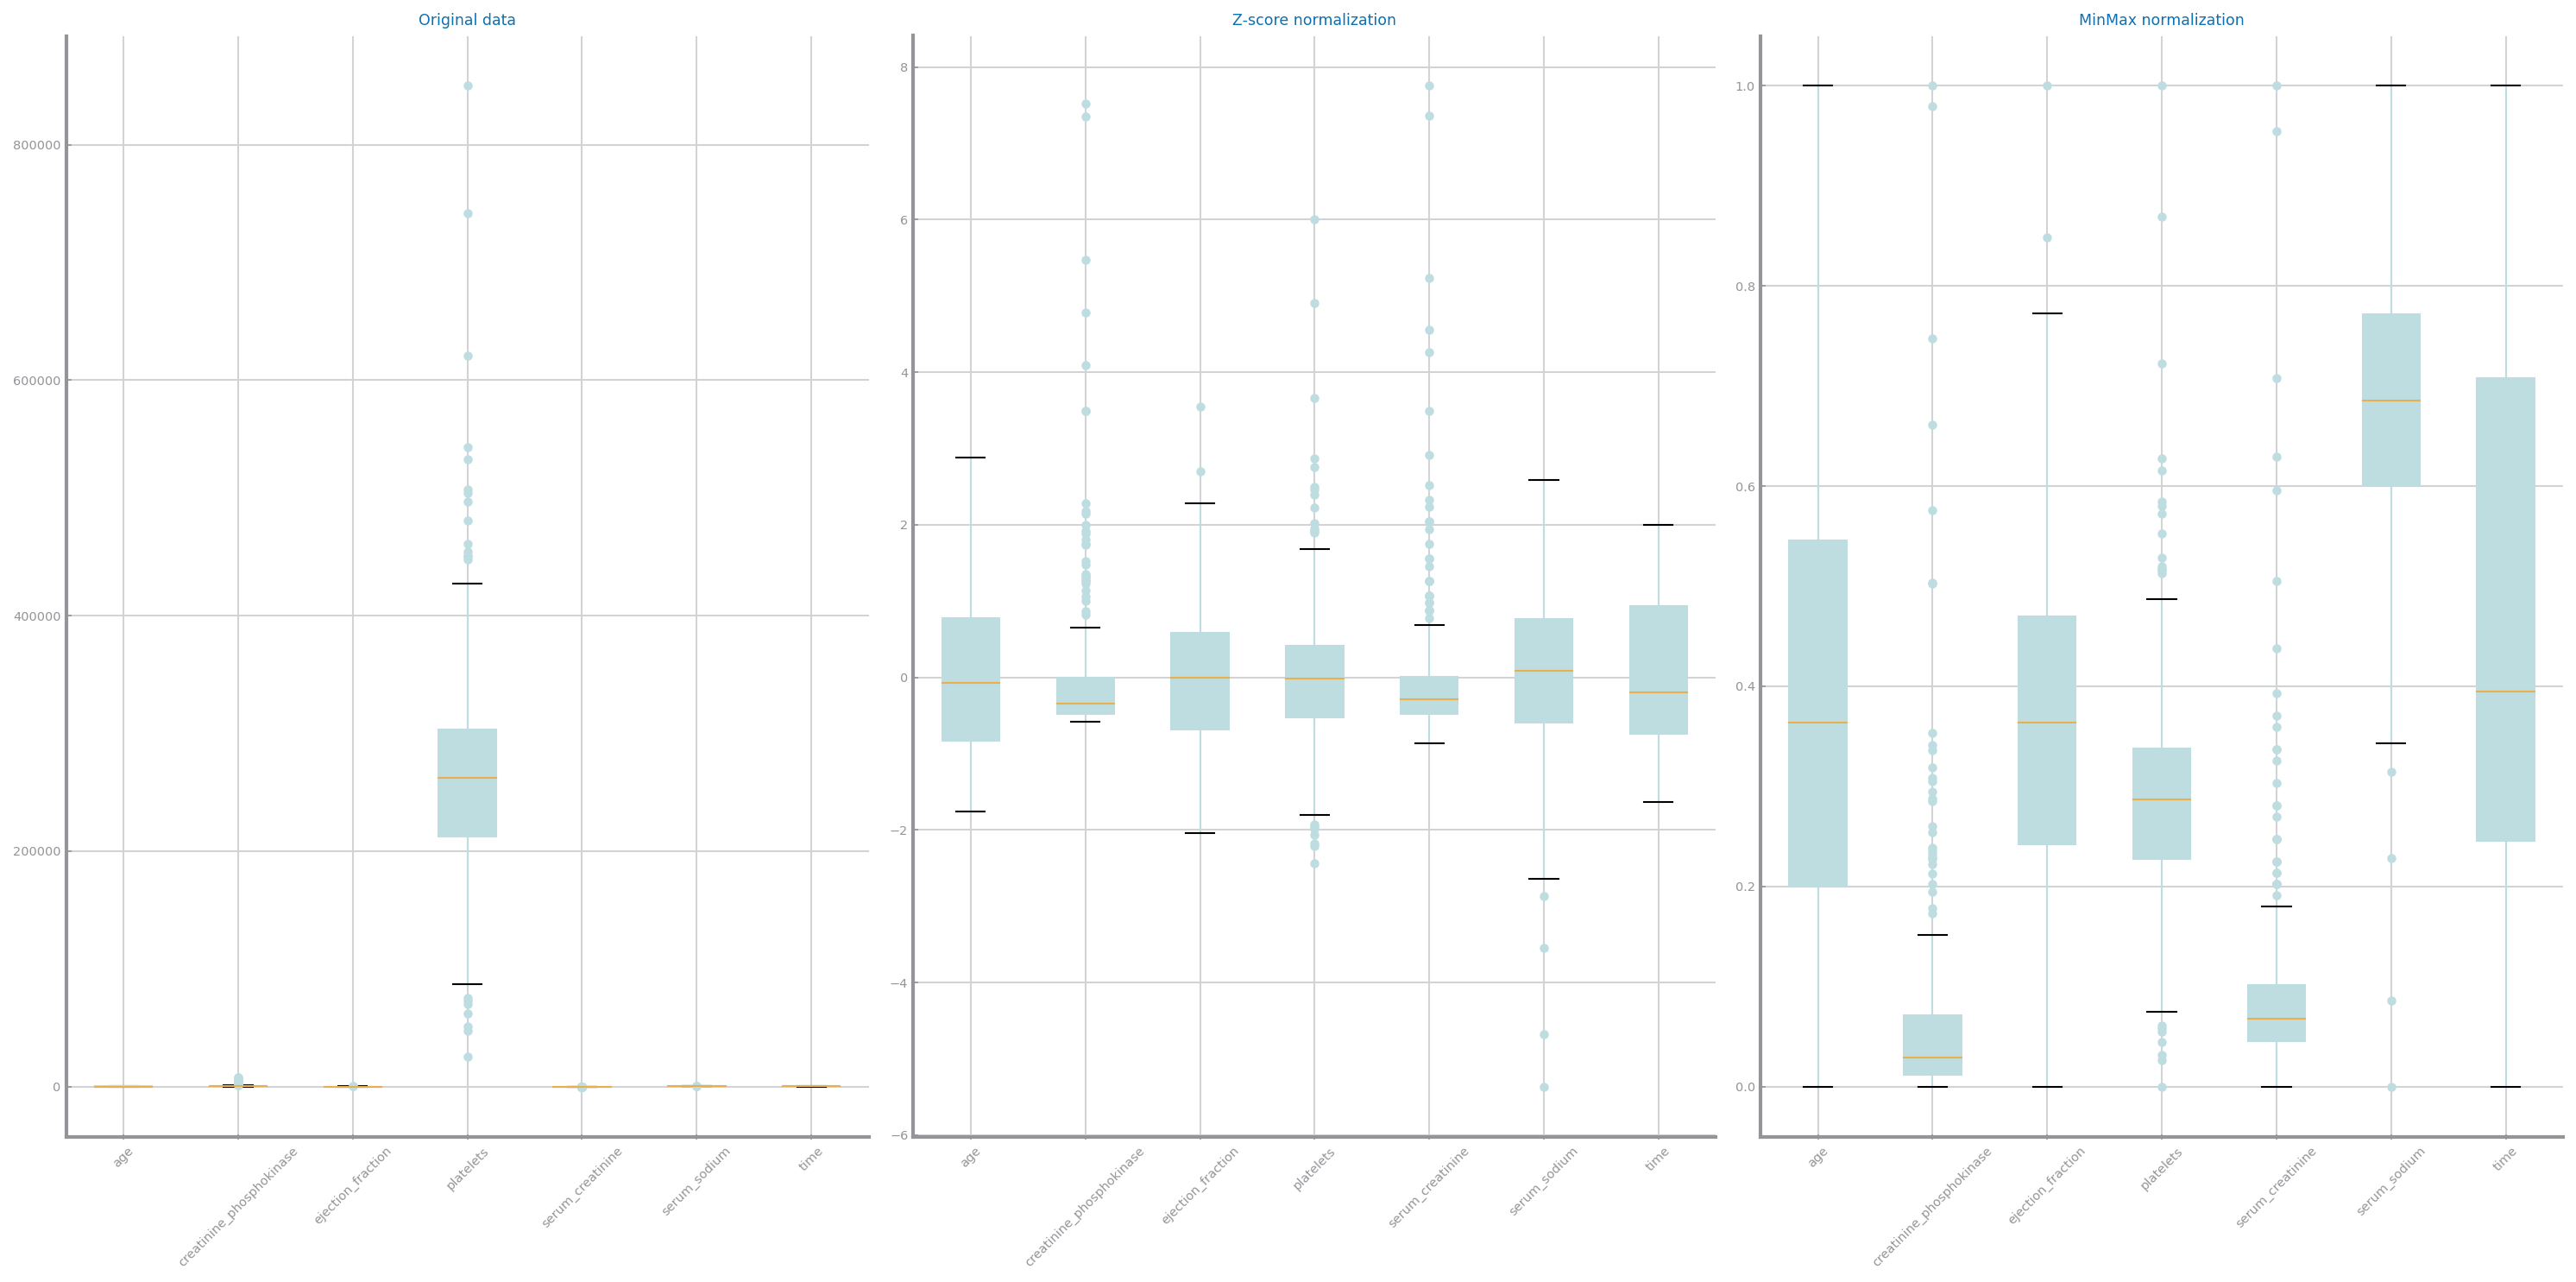

In [65]:
df_nr = pd.DataFrame(hf_data, columns=hf_data.select_dtypes(include=['float64','int64']).columns) 
df_sb = pd.DataFrame(hf_data, columns=hf_data.select_dtypes(include=['bool']).columns)

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
norm_data_zscore = pd.DataFrame(transf.transform(df_nr), columns=df_nr.columns)
norm_data_zscore = norm_data_zscore.join(df_sb, how='right')
norm_data_zscore.describe(include='all')

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
norm_data_minmax = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_minmax = norm_data_minmax.join(df_sb, how='right')
norm_data_minmax.describe(include='all')


import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(20,10),squeeze=False)

axs[0, 0].set_title('Original data')
df_nr[df_nr.columns].boxplot(ax=axs[0, 0], whis=1.5)
axs[0, 0].tick_params(axis='x', rotation=45)

axs[0, 1].set_title('Z-score normalization')
norm_data_zscore[df_nr.columns].boxplot(ax=axs[0, 1], whis=1.5)
axs[0, 1].tick_params(axis='x', rotation=45)

axs[0, 2].set_title('MinMax normalization')
norm_data_minmax[df_nr.columns].boxplot(ax=axs[0, 2], whis=1.5)
axs[0, 2].tick_params(axis='x', rotation=45)

fig.tight_layout()

## Naive Bayes

### Leave one out

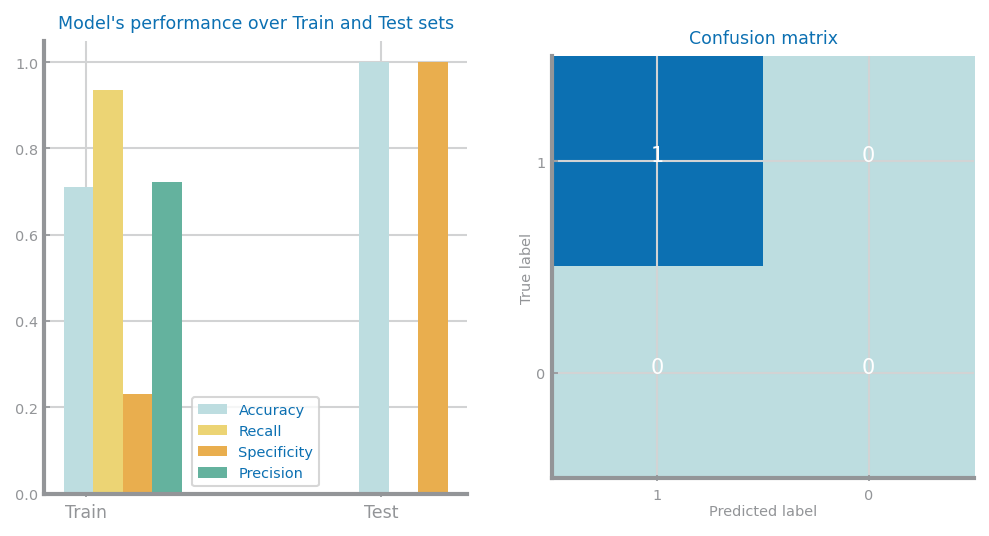

In [124]:
hf_df = hf_data_raw.drop(columns=['time'])
y: np.ndarray = hf_df.pop('DEATH_EVENT').values
X: np.ndarray = hf_df.values
labels = pd.unique(y)

loo = LeaveOneOut()

opts=[]
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = GaussianNB()
    clf.fit(X_train, y_train)
    prd_trn = clf.predict(X_train)
    prd_tst = clf.predict(X_test)
    if y[test_index][0] == 1 and prd_tst[0] == 1:
        opts.append((y_train, prd_trn, y_test, prd_tst))

from random import choice
trnY, prd_trn, tstY, prd_tst = choice(opts)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

### No scaling

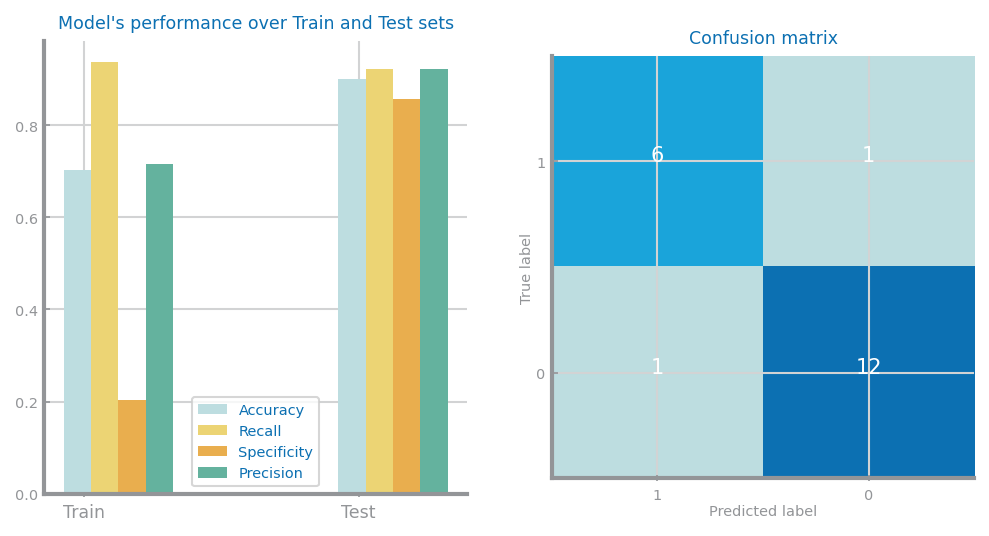

In [100]:
hf_df = hf_data_raw.drop(columns=['time'])
y: np.ndarray = hf_df.pop('DEATH_EVENT').values
X: np.ndarray = hf_df.values
labels = pd.unique(y)

trnY, prd_trn, tstY, prd_tst, trnX, tstX = KFold(X, y, 15) #fazer com menos grupos
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

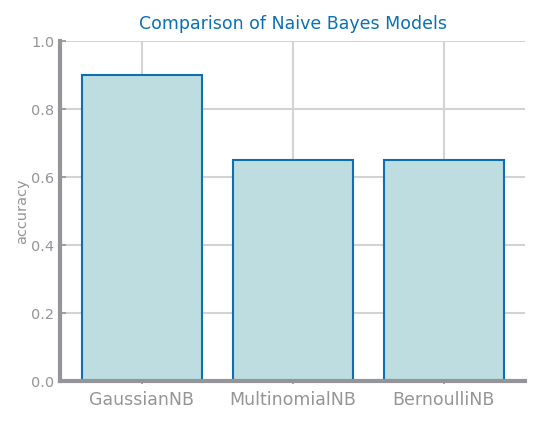

In [81]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

### Standardized

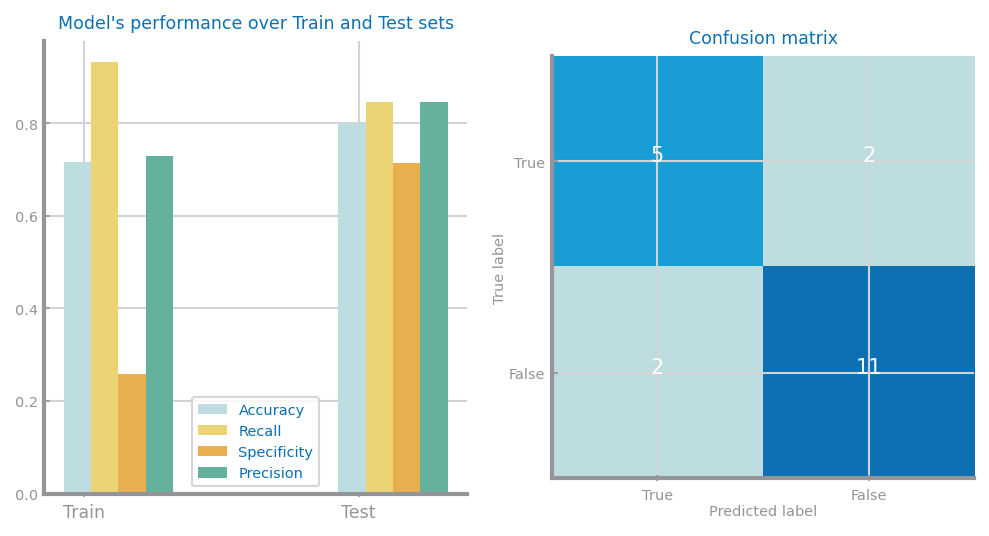

In [101]:
hf_df = norm_data_zscore.copy().drop(columns=['time'])
y: np.ndarray = hf_df.pop('DEATH_EVENT').values
X: np.ndarray = hf_df.values
labels = pd.unique(y)

trnY, prd_trn, tstY, prd_tst, trnX, tstX = KFold(X, y, 15)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

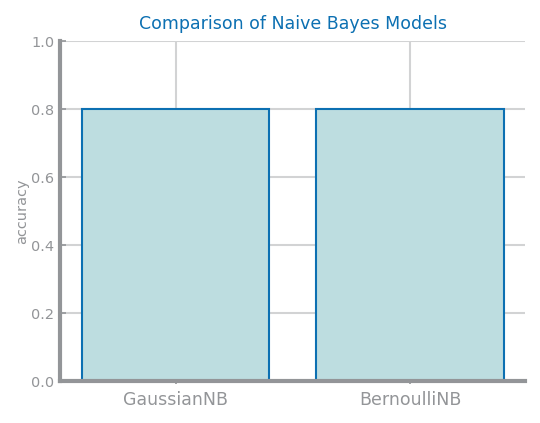

In [86]:

estimators = {'GaussianNB': GaussianNB(),
              #'MultinomialNB': MultinomialNB(), 
              'BernoulliNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

### Normalized

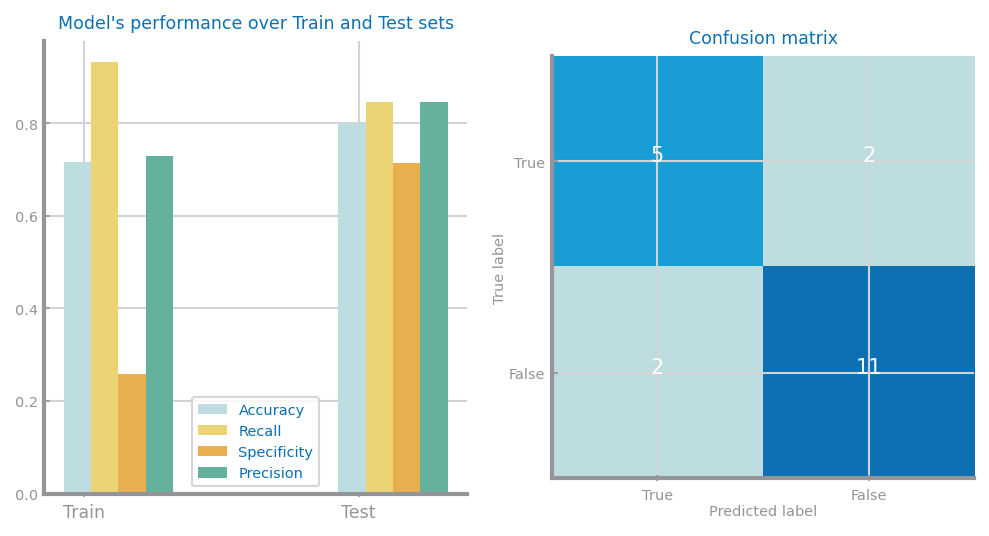

In [102]:
hf_df = norm_data_minmax.copy().drop(columns=['time'])
y: np.ndarray = hf_df.pop('DEATH_EVENT').values
X: np.ndarray = hf_df.values
labels = pd.unique(y)

trnY, prd_trn, tstY, prd_tst, trnX, tstX = KFold(X, y, 15)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

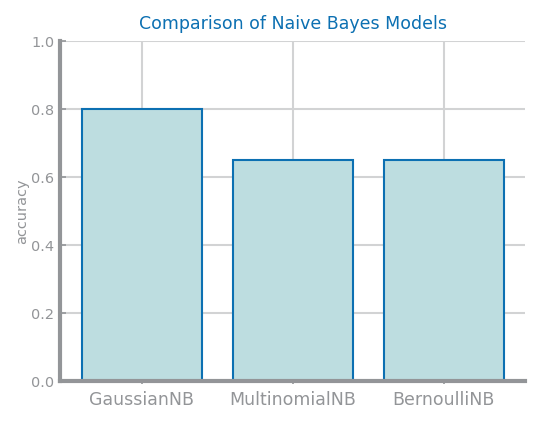

In [88]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

## KNN

### No scaling

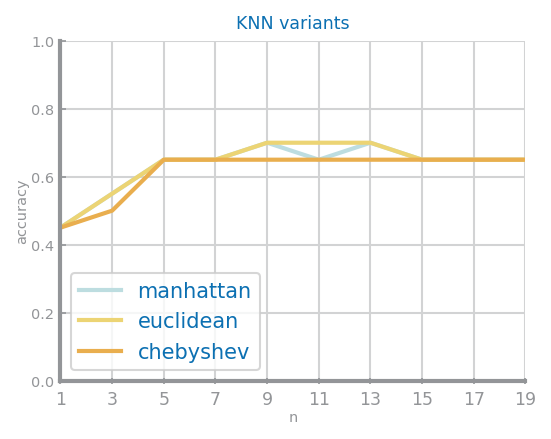

Best results with 5 neighbors and chebyshev


In [111]:
hf_data_raw_2 = hf_data_raw.drop(columns=['time'])
y: np.ndarray = hf_data_raw_2.pop('DEATH_EVENT').values
X: np.ndarray = hf_data_raw_2.values
labels = pd.unique(y)

trnY, prd_trn, tstY, prd_tst, trnX, tstX = KFold(X, y, 15)

nvalues, values = KNN(trnX, trnY, tstY, prdY)

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

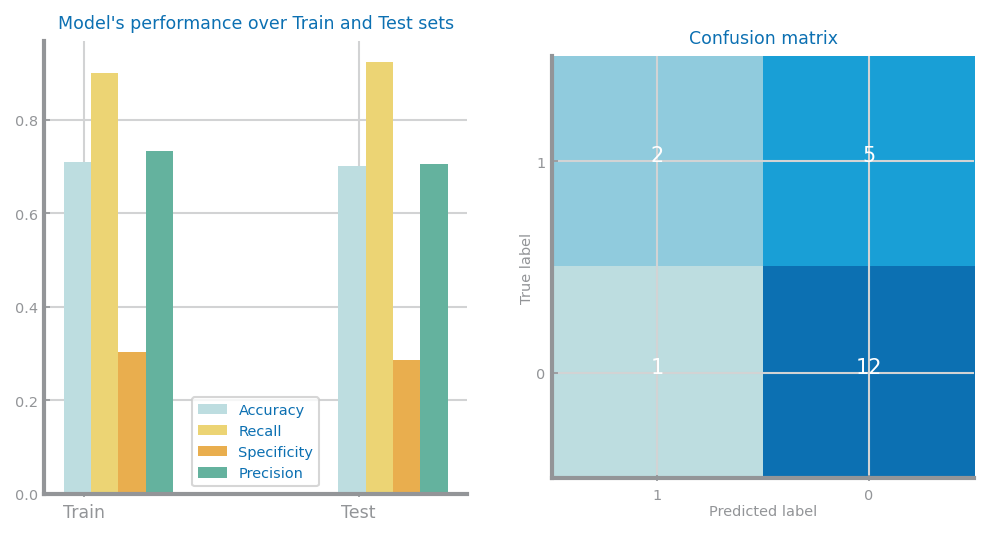

In [90]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

### Standardized

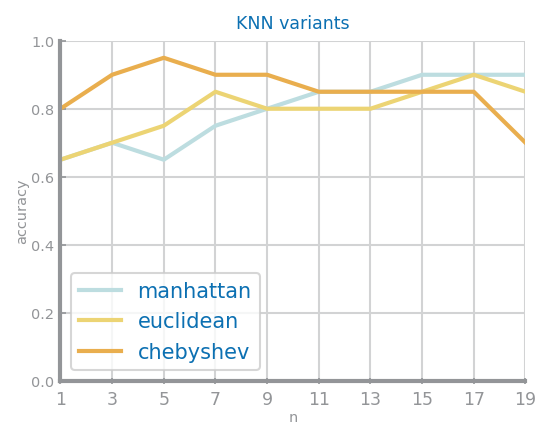

Best results with 5 neighbors and chebyshev


In [115]:
hf_df = norm_data_zscore.copy().drop(columns=['time'])
y: np.ndarray = hf_df.pop('DEATH_EVENT').values
X: np.ndarray = hf_df.values
labels = pd.unique(y)

trnY, prd_trn, tstY, prd_tst, trnX, tstX = KFold(X, y, 15)
nvalues, values = KNN(trnX, trnY, tstY, prdY)

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

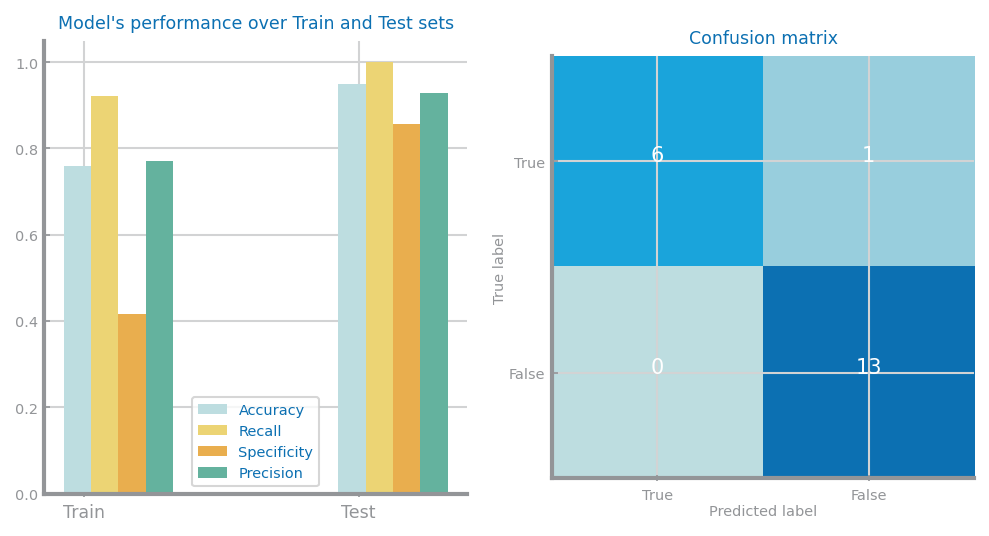

In [116]:

clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

### Normalized

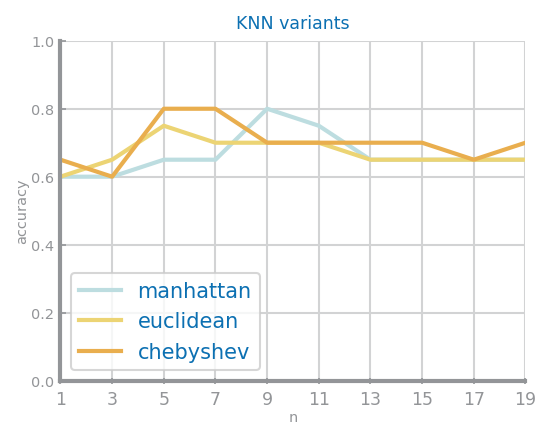

Best results with 5 neighbors and chebyshev


In [112]:
hf_df = norm_data_minmax.copy().drop(columns=['time'])
y: np.ndarray = hf_df.pop('DEATH_EVENT').values
X: np.ndarray = hf_df.values
labels = pd.unique(y)

trnY, prd_trn, tstY, prd_tst, trnX, tstX = KFold(X, y, 15)

nvalues, values = KNN(trnX, trnY, tstY, prdY)

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

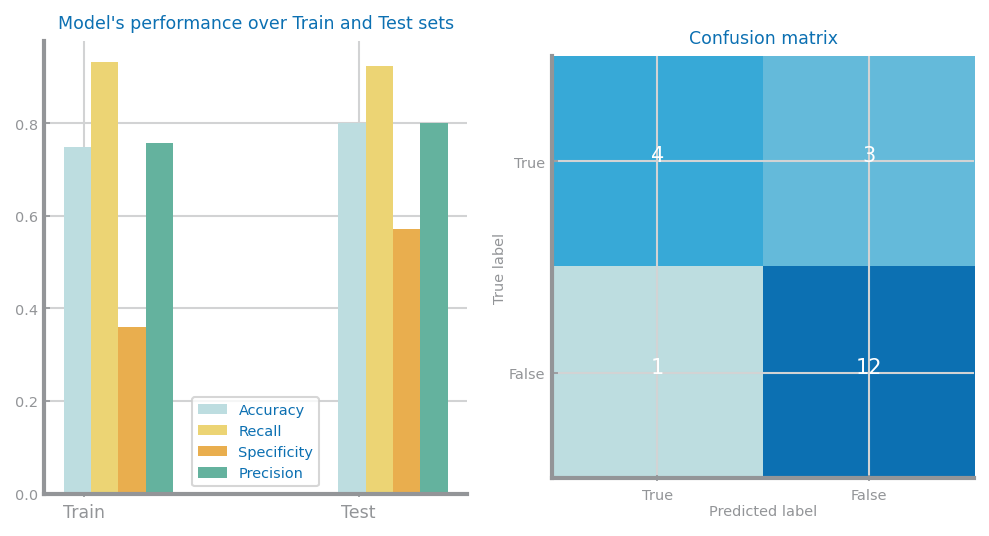

In [113]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

# Toxicity Dataset

## Scaling

All of the variables are binary and with values from 0 to 1 and so there is no need to scale the variables, since they all have the same scale.

## Naive Bayes

8992


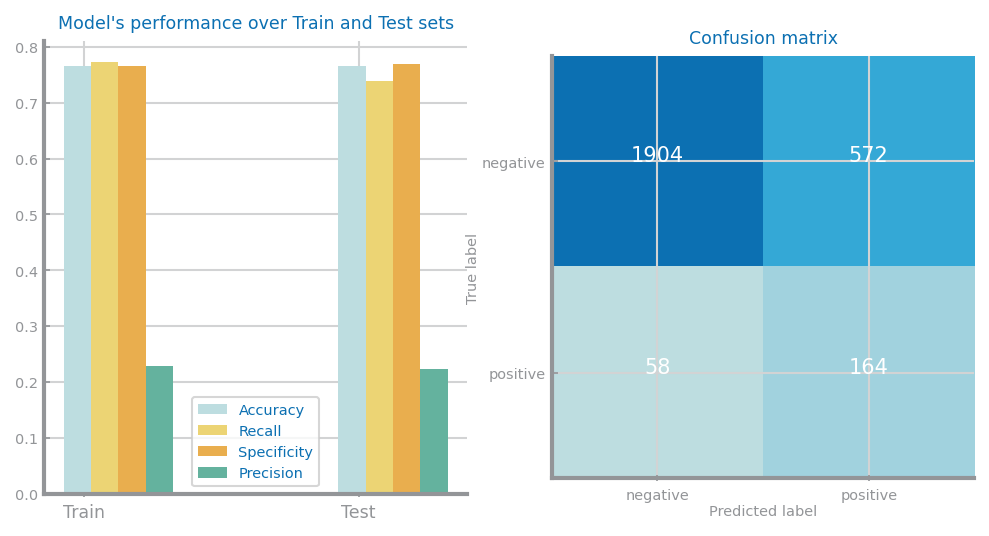

In [10]:
print(t_data_raw.shape[0])
t_data_raw_2 = t_data_raw.copy()
y: np.ndarray = t_data_raw_2.pop(1024).values
X: np.ndarray = t_data_raw_2.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

clf = GaussianNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

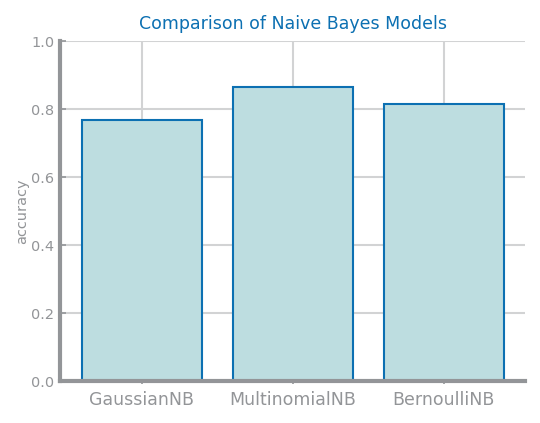

In [11]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

## KNN

manhattan 1
manhattan 3
manhattan 5
manhattan 7
manhattan 9
manhattan 11
manhattan 13
manhattan 15
manhattan 17
manhattan 19
euclidean 1
euclidean 3
euclidean 5
euclidean 7
euclidean 9
euclidean 11
euclidean 13
euclidean 15
euclidean 17
euclidean 19
chebyshev 1
chebyshev 3
chebyshev 5
chebyshev 7
chebyshev 9
chebyshev 11
chebyshev 13
chebyshev 15
chebyshev 17
chebyshev 19


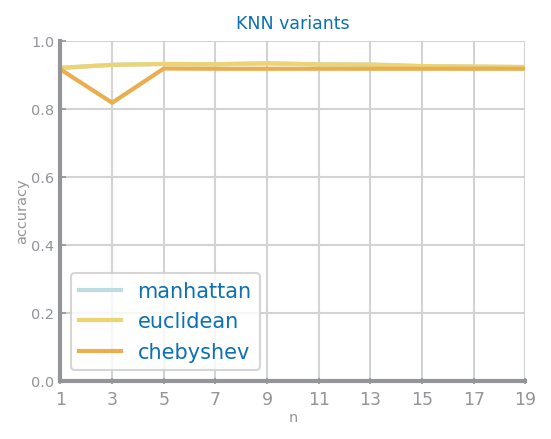

Best results with 9 neighbors and manhattan


In [3]:
t_data_raw_2 = t_data_raw.copy()
y: np.ndarray = t_data_raw_2.pop(1024).values
X: np.ndarray = t_data_raw_2.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    for n in nvalues:
        print(d, n)
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

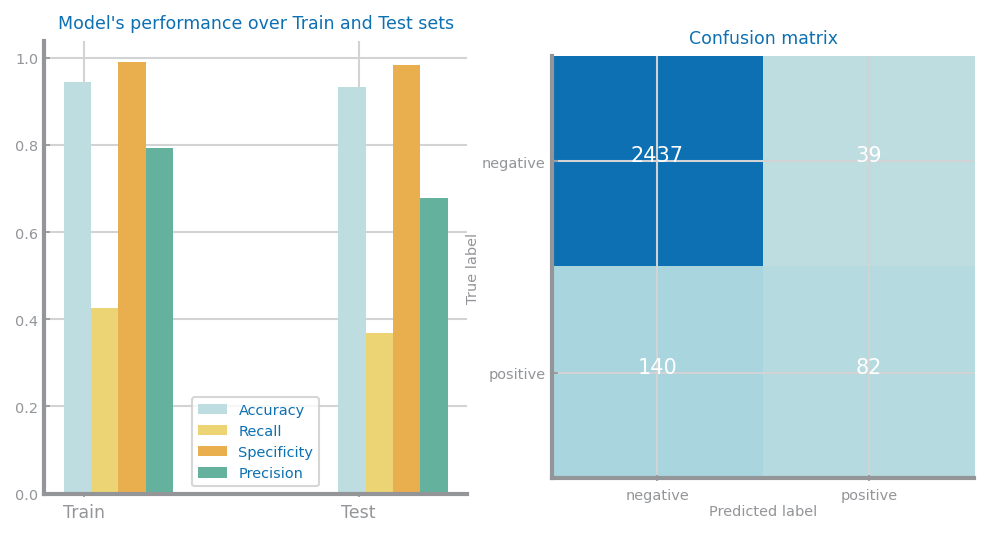

In [4]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)